# San Francisco Fire Department (SFFD) - Fire Incidents

## 1. Motivation
One of the most important aspects of every fire department is the response time, or how quickly a fire department is at arriving on a scene. Every second can be critical. San Francisco's Open Data project has made it possible to find out these response times.

The dataset consist of approx. 430.000 incidents (rows) from 2003, with 63 attributes (columns).

Some of the attributes are more helpful than others in determining the response time, and it will be interesting to see if it is possible to predict the response time given some of the attributes.

The dataset has both timestamps for alarm time and arrival time, which have to be subtracted from each other to get the response time. Approx. 85% incidents have geolocation, which will be very useful as one of the more critical attributes used to predict the response time.

Furthermore, each fire incident has fire station attached to it. The distance from the fire station to the incident will also be useful.

San Francisco Fire Department (SFFD) has 45 fire stations located across San Francisco and they are further divided into 10 battalions. Size of a battalion ranges from 4 to 7 fire stations. Fire stations close to each other belong in the same battalion.

Three machine learning tools were used in this report:
* Multiple regression to predict the response time
* Decision tree to predict in which area a given fire incident was likely to happen
* K-means clustering to identify clusters in San Francisco based on building fires

The goal of the report is try to see trends in the data extracted from the dataset, by using relevant and good visualization. And utilizing those trends with machine learning tools to make predictions and validate if they are performing well.

The dataset can be downloaded [here](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric).

## 2. Basic stats

The dataset did not contain the geolocation for the 45 fire stations and therefore, we had to download those locations ourselves. The geolocations for the fire stations are important because it makes it possible to get the distance from the fire station to the incident, which is one of the attributes that will play a part in predicting the response time.

Fire stations' addresses and names were scraped from the [official SFFD website](http://sf-fire.org/fire-station-locations). Latitude and longitude were then downloaded by using Google Maps API.

Hereafter, the chapters will be broken up by code.

### 2.1 Data cleaning and preprocessing
We start by importing all Python packages that will be used.

In [67]:
import csv
import json
import urllib
from bs4 import BeautifulSoup
import re
import requests
import geoplotlib
from geoplotlib.utils import BoundingBox
from datetime import datetime, date
import calendar
from math import radians, cos, sin, asin, sqrt
from collections import defaultdict
import numpy as np
from collections import Counter
import operator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.linear_model as lm
from sklearn import cross_validation
from random import randint
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import tree

In [2]:
# SFFD Battalions and their fire stations
battalion01 = ["02", "13", "28", "41"]
battalion02 = ["01", "06", "29", "36"]
battalion03 = ["04", "08", "35", "48"]
battalion04 = ["03", "16", "38", "51"]
battalion05 = ["05", "10", "12", "21"]
battalion06 = ["07", "11", "24", "26", "32"]
battalion07 = ["14", "22", "31", "34"]
battalion08 = ["18", "20", "23", "40"]
battalion09 = ["15", "19", "33", "39", "43"]
battalion10 = ["09", "17", "25", "37", "42", "44", "49"]

battalions = [battalion01, battalion02, battalion03, battalion04, battalion05,
              battalion06, battalion07, battalion08, battalion09, battalion10]

In [3]:
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December"]

parts_of_the_day = ["morning (6:00 - 10:59)", "midday (11:00 - 14:59)", "afternoon (15:00 - 17:59)",
                    "evening (18:00 - 23:59)", "night (0:00 - 5:59)"]

We start by going through the csv-file and add to a dictionary where each incident is key and has total of 9 attributes.

Attributes chosen:
* alarm_DtTm - The time the alarm went of or a call was made to 911
* arrival_DtTm - The arrival time on scene
* station_area - Fire Station's number
* category - type of fire incident
* district - district in San Francisco where the fire incident occur
* location - location of fire incident (latitude and longitude)

In [4]:
sffd_incidents = {}
with open("sfdp_incidents.csv") as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for entry in reader:
        sffd_incidents[
            entry["Incident Number"]
        ] = {
        "alarm_DtTm":          entry["Alarm DtTm"],
        "arrival_DtTm":        entry["Arrival DtTm"],
        "station_area":        entry["Station Area"],
        "category":            entry["Primary Situation"],
        "district":            entry["Neighborhood  District"],
        "location":            entry["Location"]
        }

In [5]:
print "Total number of incidents: %d" % len(sffd_incidents)

Total number of incidents: 429364


In [6]:
print "Example from 'sffd_incidents':"
print sffd_incidents["14000364"]

Example from 'sffd_incidents':
{'category': '733 - smoke detector activation/malfunction', 'district': 'Pacific Heights', 'arrival_DtTm': '01/01/2014 03:16:22 PM', 'alarm_DtTm': '01/01/2014 03:11:32 PM', 'location': '(37.7880120000297, -122.426228)', 'station_area': '38'}


In [7]:
# Download html page which has SFFD fire stations' addresses
link = "http://sf-fire.org/fire-station-locations"
f = urllib.urlopen(link)
myfile = f.read()

soup = BeautifulSoup(myfile, 'html.parser')

# Addresses are located within the first 'tbody' tag
address_block = soup.find_all('tbody')[0]

In [8]:
# Get number for each fire station and add to a list
stations_number = []
for num in address_block.find_all('strong'):
    stations_number.append(str(re.search(r'\d+', num.get_text()).group().zfill(2)))
    
# Get address for each fire station and add to a list
stations_address = []
for address in address_block.find_all('a'):
    # Encode string to unicode
    address_unicode = address.get_text().encode('utf-8')
    # Replace NO-BREAK SPACE utf-8 with whitespace
    address_clean = address_unicode.replace("\xc2\xa0", " ")
    # Add address to a list
    stations_address.append(address_clean)

In [9]:
# Access geo location using Google Maps API and add to a dictionary
API_KEY = "YOUR_API_KEY"

stations_location = {}
for idx, station in enumerate(stations_number):
    # All fire stations are in the format: 'Fire Station #' in Google Maps except for Fire Station no. 4
    if (station != "04"):
        search_address = "san+francisco+fire+station+%d,+San+Francisco,+CA" % int(station)
    else:
        # Format: 'Fire Station No. 4'
        search_address = "san+francisco+fire+station+no.+%d,+San+Francisco,+CA" % int(station)
    
    # Construct the search link
    link = "https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s" % (search_address, API_KEY)
    
    # Get JSON object from the request
    response = requests.get(link)
    json = response.json()
        
    # Get latitude and longitude from the response
    latitude = json["results"][0]["geometry"]["location"]["lat"]
    longitude = json["results"][0]["geometry"]["location"]["lng"]
    
    # Add address, latitude and longitude to a dictionary where station number is key    
    stations_location[station] = {"address": stations_address[idx],
                                  "lat": latitude,
                                  "lon": longitude}

In [10]:
print "Number of fire stations in San Francisco: %d" % len(stations_location)

Number of fire stations in San Francisco: 45


Fire Station no. 16 got the wrong coordinates because it is was [closed in October 2016 due to constructions](http://www.sfearthquakesafety.org/firestation16.html). The Google Maps API gave it the coordinates for location close to its nearest fire station (no. 10).

Therefore, we add the coordinates manually for Fire Station no. 16.

In [11]:
print "Coordinates for Fire Stations 10 and 16 (before update):"
print stations_location["10"]["lat"], stations_location["10"]["lon"]
print stations_location["16"]["lat"], stations_location["16"]["lon"]

# Update the dictionary with the right values
stations_location["16"]["lat"] = 37.798666
stations_location["16"]["lon"] = -122.436747

print "Coordinates for Fire Station 16 (after update):"
print stations_location["16"]["lat"], stations_location["16"]["lon"]

Coordinates for Fire Stations 10 and 16 (before update):
37.785648 -122.446634
37.7857943 -122.4466681
Coordinates for Fire Station 16 (after update):
37.798666 -122.436747


We gather all the geolocations for the fire stations and plot them on a map to get a better sense of their location. Each fire station gets a color code based on their battalion.

In [12]:
# Function for getting latitudes and longitudes ready for plotting
# Returns dictionary of latitudes and longitudes
def get_lat_lon_to_dict(battalion):
    lat = []
    lon = []
    for station in battalion:
        lat.append(stations_location[station]["lat"])
        lon.append(stations_location[station]["lon"])
    
    geo_data_for_plotting = {"lat": lat,
                             "lon": lon}
    
    return geo_data_for_plotting

In [13]:
# 10 distinctive colors
colors = [[149, 165, 166], [230, 126, 34], [0, 215, 255], [255, 196, 0], [232, 0, 11],
          [0, 0, 0], [138, 43, 226], [3, 237, 58], [0, 63, 255], [26, 188, 156]]

In [14]:
# Plot the location of fire stations in San Francisco
bbox = BoundingBox(north=37.8265609, west=-122.5046487, south=37.7108786, east=-122.3694425)
geoplotlib.set_bbox(bbox)

# Every battalion gets assigned different color based on their battalion
for idx, battalion in enumerate(battalions):
    geoplotlib.dot(get_lat_lon_to_dict(battalion), colors[idx])
    
geoplotlib.inline()

Next is to prepare functions which will be used when we go through 'sffd_incidents', because we need to create more attributes.

The first function is to simply determine which battalion the fire station belongs to.

In [15]:
def get_battalion(fire_station):
    if (fire_station in battalion01):
        return "B01"
    elif (fire_station in battalion02):
        return "B02"
    elif (fire_station in battalion03):
        return "B03"
    elif (fire_station in battalion04):
        return "B04"
    elif (fire_station in battalion05):
        return "B05"
    elif (fire_station in battalion06):
        return "B06"
    elif (fire_station in battalion07):
        return "B07"
    elif (fire_station in battalion08):
        return "B08"
    elif (fire_station in battalion09):
        return "B09"
    else:
        return "B10"

In [16]:
# Write to a csv-file the location of fire stations and the battalion they belong to
fire_stations_location = []
for key, value in stations_location.iteritems():
    battalion = get_battalion(key)
    address = value["address"]
    lat = value["lat"]
    lon = value["lon"]
    fire_stations_location.append([key, battalion, address, lat, lon])
    
    with open("./data/fire_stations_location.csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerow(("fire_station", "battalion", "address", "lat", "lon"))
        writer.writerows(fire_stations_location)

This function converts the AM/PM time to 24-hour time.

In [17]:
def convert_time(date_time):
    time = date_time.split(" ")[1]
    am_pm = date_time.split(" ")[2]
    hr = int(time.split(":")[0])
    
    if(am_pm == "PM") and (hr != 12):
        hr = hr+12
    elif(am_pm == "AM") and (hr == 12):
        hr = hr-12
    else:
        hr = hr
        
    return str(hr).zfill(2) + time[2:]

Using the datetime package we get the response time. The datetime package takes the time in the format HH:MM:SS and returns the response time in seconds.

In [18]:
def calc_time_diff(alarm, arrival):
    alarm_time = convert_time(alarm)
    arrival_time = convert_time(arrival)

    FMT = "%H:%M:%S"
    tdelta = datetime.strptime(arrival_time, FMT) - datetime.strptime(alarm_time, FMT)
    return tdelta.seconds

The next four functions all use the 'alarm_DtTm' attribute and split it into the day, the month, the year and the weekday of the incident.

In [19]:
def get_day(alarm_time):
    date = alarm_time.split(" ")[0]
    day = int(date.split("/")[1])
    
    return day

In [20]:
def get_month(alarm_time):
    date = alarm_time.split(" ")[0]
    month = int(date.split("/")[0])
    
    return month

In [21]:
def get_year(alarm_time):
    date = alarm_time.split(" ")[0]
    year = int(date.split("/")[2])
    
    return year

In [22]:
def get_weekday(alarm_time):
    date = alarm_time.split(" ")[0]
    month, day, year = date.split("/")
    weekday = int(calendar.weekday(int(year), int(month), int(day)))
    
    return weekday

'get_part_of_the_day' function divides the day into five parts. This attribute will be used in the Decision tree classifier.

In [23]:
def get_part_of_the_day(hr):
    if (0 <= hr <= 5):
        return 0
    elif (6 <= hr <= 10):
        return 1
    elif (11 <= hr <= 14):
        return 2
    elif (15 <= hr <= 17):
        return 3
    else:
        return 4

Not all fire codes are in the right format. The right format is 3 digits followed by the description of the fire code. This function removes unwanted characters from the fire code and makes sure that every fire code is in the same format.

In [24]:
# Cleans fire codes and returns it '### description'
def category(category):
    clean_str = category.replace(" -", "")
    # Remove the 4th digit if fire code starts with 4 digits
    if (re.search('\d\d\d\d', clean_str)):
        return clean_str.replace(clean_str[3], "")
    else:
        return clean_str

The function 'get_lat_lon' removes the parentheses and returns the latitude and longitude separately.

In [25]:
def get_lat_lon(coordinates):
    lat, lon = map(float, coordinates.strip('()').split(','))
    return lat, lon

[Havesine formula](https://en.wikipedia.org/wiki/Haversine_formula) is a good choice when calculating the difference of geolocations within small distances. This returns the distance between two locations in meters (straight line). Unfortunately, it is not possible to find out the distance based on the route the fire truck took, but this should hopefully average out by all fire incidents.

In [26]:
def get_distance(fire_station, lat01, lon01):
    # Get latidutes and longitudes from a fire station
    lat02 = stations_location[fire_station]["lat"]
    lon02 = stations_location[fire_station]["lon"]   
    # Convert decimal degrees to radians 
    lon01, lat01, lon02, lat02 = map(radians, [lon01, lat01, lon02, lat02])
    # Haversine formula 
    dlon = lon02 - lon01
    dlat = lat02 - lat01
    a = sin(dlat/2)**2 + cos(lat01) * cos(lat02) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # Radius of the earth in m
    earth_radius = 6367000
    m = earth_radius * c
    return m

It is not enough to know the response time, it also vital to know how much distance was covered relative to the response time. We get this by dividing the distance with the response time, and acquire meters per seconds. This attribute will play a big role in the multiple regression.

In [27]:
def get_m_per_s(distance, response_time):
    if (response_time != 0):
        return distance/response_time
    else:
        return "N/A"

The following code is to find duplicated fire codes and make sure that there is only one instance of each fire code.

Example of duplicated fire codes can been seen further down.

This was a vital step as this reduced the fire codes from 245 to 176. Fire codes are used in the decision tree classifier.

In [28]:
# Get fire codes and their descriptions and add to a list
fire_incidents_fire_codes = []
for key, value in sffd_incidents.iteritems():
    # Ignore fire codes that are not 3 digits
    if (re.search('\d\d\d', category(value["category"]))):
        fire_incidents_fire_codes.append(category(value["category"]))

# Number of fire codes before removing duplicates
print "Fire codes (with duplicates): %d" % len(set(fire_incidents_fire_codes))
print "\nExample of duplicated fire codes:"
print sorted(set(fire_incidents_fire_codes))[2:4]

# Removes duplicated fire codes and descriptions
fire_codes = []
fire_codes_info = []
fire_codes_duplicates = []
for fire_code in sorted(set(fire_incidents_fire_codes)):
    if (fire_code[0:3] not in fire_codes_duplicates):
        fire_codes.append(fire_code[0:3])
        fire_codes_info.append(fire_code[4:])
        fire_codes_duplicates.append(fire_code[0:3])
        
# Number of fire codes
print "\nFire codes: %d" % len(fire_codes)
print "Fire codes descriptions: %d" % len(fire_codes_info)

Fire codes (with duplicates): 245

Example of duplicated fire codes:
['112 fires in struct. other than in a bldg.', '112 fires in structure other than in a building']

Fire codes: 176
Fire codes descriptions: 176


In [29]:
# Example from 'fire_codes' and 'fire_codes_info'
for idx, value in enumerate(fire_codes[0:10]):
    print value, fire_codes_info[idx]

100 fire, other
111 building fire
112 fires in struct. other than in a bldg.
113 cooking fire, confined to container
114 chimney or flue fire, confined to chimney or flue
115 incinerator overload or malfunction, fire confined
116 fuel burner/boiler mal., fire coinfined
117 commercial compactor fire, confined to rubbish
118 trash or rubbish fire, contained
120 fire in mobile prop. used as a fixed struc., other


Here we are going through the 'sffd_incidents' dictionary and creating a new dictionary with all the new attributes explained earlier.

Fire incident id is key, and each key has these attributes:
fire_station, battalion, day, month, year, weekday, hour, part_of_the_day, response_time, fire_code, fire_code_info, district, latitude, longitude, distance and m_per_s.

All fire incidents which have alarm_DtTm and arrival_DtTm, and happend prior to 2017 are included in the new dataset.

In [30]:
fire_incidents_info = {}
for key, value in sffd_incidents.iteritems():
    if (value["alarm_DtTm"] != "" and
        value["arrival_DtTm"] != "" and        
        value["station_area"] in stations_number and
        get_year(value["alarm_DtTm"]) < 2017 and
        re.search('\d\d\d', category(value["category"]))):
        
        fire_station = value["station_area"]
        battalion = get_battalion(fire_station)
        response_time = calc_time_diff(value["alarm_DtTm"], value["arrival_DtTm"])
        day = get_day(value["alarm_DtTm"])
        month = get_month(value["alarm_DtTm"])
        year = get_year(value["alarm_DtTm"])
        weekday = get_weekday(value["alarm_DtTm"])
        hour = int(convert_time(value["alarm_DtTm"])[0:2])
        part_of_the_day = get_part_of_the_day(hour)
        
        fire_code_idx = fire_codes.index(value["category"][0:3])
        fire_code = fire_codes[fire_code_idx]
        fire_code_info = fire_codes_info[fire_code_idx]
        
        if (value["district"] != ""):
            district = value["district"]
        else:
            district = "N/A"
        
        if (value["location"] != ""):
            latitude = get_lat_lon(value["location"])[0]
            longitude = get_lat_lon(value["location"])[1]
            distance = get_distance(fire_station, latitude, longitude)
            m_per_s = get_m_per_s(response_time, distance)
            
        else:
            latitude = "N/A"
            longitude = "N/A"
            distance = "N/A"
        
        fire_incidents_info[key] = {"fire_station": fire_station,
                                    "battalion": battalion,
                                    "day": day,
                                    "month": month,
                                    "year": year,
                                    "weekday": weekday,
                                    "hour": hour,
                                    "part_of_the_day": part_of_the_day,
                                    "response_time": response_time,
                                    "fire_code": fire_code,
                                    "fire_code_info": fire_code_info,
                                    "district": district,
                                    "lat": latitude,
                                    "lon": longitude,
                                    "distance": distance,
                                    "m_per_s": m_per_s}

### 2.2 Dataset stats

Now we are ready to dissect this subset of the original dataset. Number of incidents excluded from the csv-file are total of 15.568, these incidents either happenend in 2017 or did not have the vital alarm_DtTm and arrival_DtTm attributes which are very important to see if there are any seasonal trends in data.

After this preprocessing we are left with 413.796 incidents to look further into.

In [31]:
print "Total number of incidents:", len(fire_incidents_info)
print "Number of incidents excluded from the csv-file:", len(sffd_incidents) - len(fire_incidents_info)

print("\n----------")
print "Example from 'fire_incidents_info':"
print fire_incidents_info["14000364"]

Total number of incidents: 413796
Number of incidents excluded from the csv-file: 15568

----------
Example from 'fire_incidents_info':
{'fire_station': '38', 'district': 'Pacific Heights', 'hour': 15, 'fire_code': '733', 'lon': -122.426228, 'part_of_the_day': 3, 'month': 1, 'm_per_s': 0.772152549146632, 'weekday': 2, 'year': 2014, 'lat': 37.7880120000297, 'fire_code_info': 'smoke detector activation due to malfunction', 'battalion': 'B04', 'day': 1, 'response_time': 290, 'distance': 375.57345413222083}


#### 2.2.1 Categories distribution
Lets start by plotting the distribution of the fire categories. As the total number of fire categories is 176, we will only plot the top 30 categories.

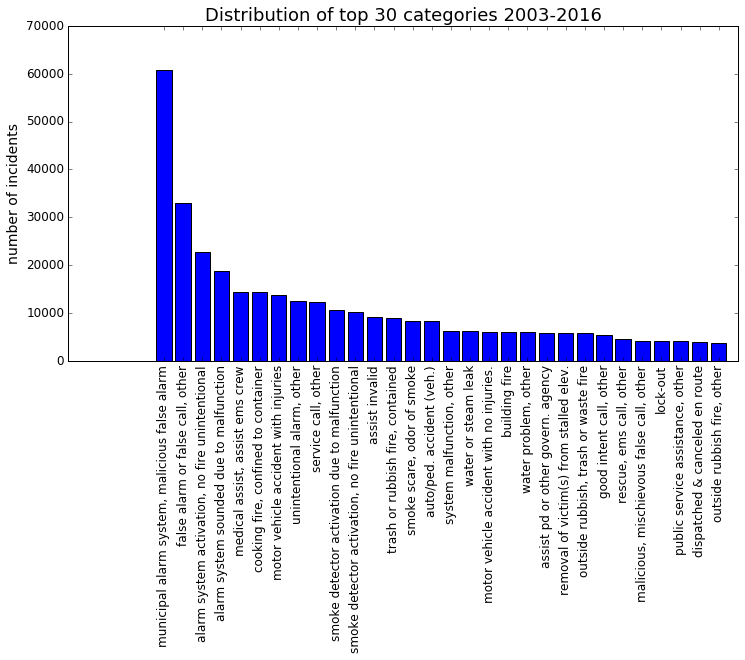

In [32]:
categories = []
for key, value in fire_incidents_info.iteritems():
    categories.append(value["fire_code_info"])
    
categories_count = Counter(categories)

categories_sorted = sorted(categories_count.items(), key=operator.itemgetter(1), reverse=True)

categories_names = [x[0] for x in categories_sorted[0:30]]
labels = range(len(categories_names))
values = [x[1] for x in categories_sorted[0:30]]

plt.figure(figsize=(12,6))
plt.bar(labels, values, align='center')
plt.title("Distribution of top 30 categories 2003-2016", fontsize=18)
plt.ylabel('number of incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(labels, categories_names, fontsize=12, rotation=90)
plt.show()

# Write to a csv-file
with open("./data/categories_top30.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(("category", "number_of_incidents"))
    writer.writerows(zip(categories_names, values))

In this plot it is very clear that the most number of categories are related to false alarms, six out of the top ten categories. This is not very interesting and we will therefore look into the categories directly linked to fire. These are fire codes starting with the digit 1, and are 39 in total.

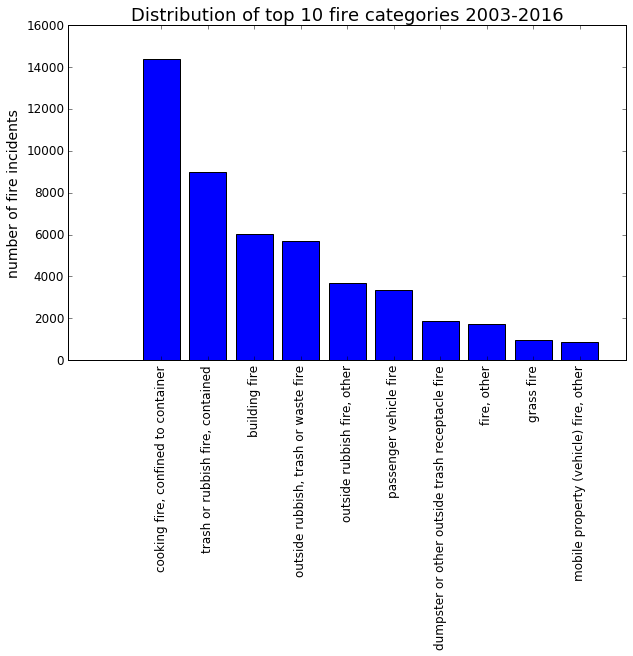

Number of fire categories: 39


In [33]:
fire_categories = []
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        fire_categories.append(value["fire_code_info"])
    
fire_categories_count = Counter(fire_categories)

fire_categories_sorted = sorted(fire_categories_count.items(), key=operator.itemgetter(1), reverse=True)

fire_categories_names = [x[0] for x in fire_categories_sorted[0:10]]
labels = range(len(fire_categories_names))
values = [x[1] for x in fire_categories_sorted[0:10]]

plt.figure(figsize=(10,6))
plt.bar(labels, values, align='center')
plt.title("Distribution of top 10 fire categories 2003-2016", fontsize=18)
plt.ylabel('number of fire incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(labels, fire_categories_names, fontsize=12, rotation=90)
plt.show()
print "Number of fire categories: %d" % len(set(fire_categories))

# Write to a csv-file
with open("./data/fire_categories_top10.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(("category", "number_of_fire_incidents"))
    writer.writerows(zip(fire_categories_names, values))

Five of these fire categories made it to the top 30 overall categories, which means, as expected, that there are far more false alarms than there are actual fires. Lets see how these fire categories are distributed by districts.

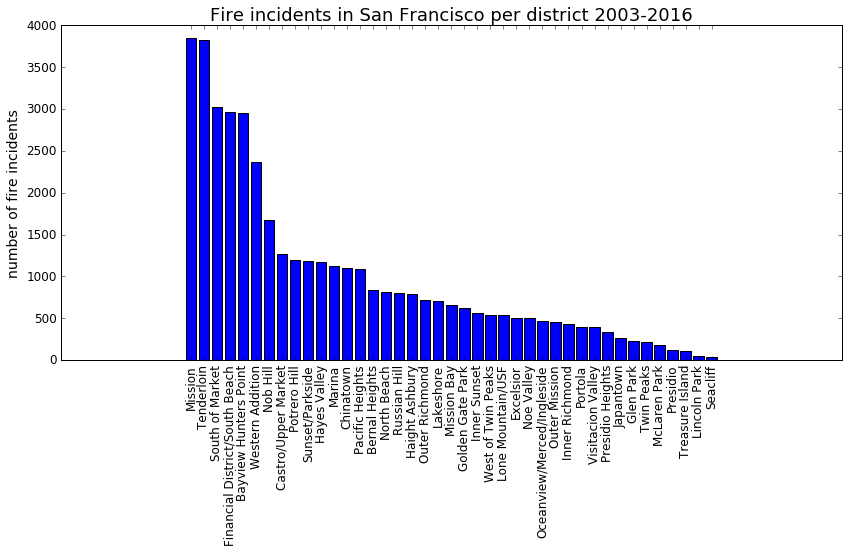

Number of districts: 41


In [34]:
fire_categories_districts = []
for key, value in fire_incidents_info.iteritems():
    if (value["district"] != "N/A" and value["fire_code"].startswith("1")):
        fire_categories_districts.append(value["district"])
        
fire_categories_districts_count = Counter(fire_categories_districts)

fire_categories_districts_sorted = sorted(fire_categories_districts_count.items(), key=operator.itemgetter(1), reverse=True)

districts_names = [x[0] for x in fire_categories_districts_sorted]
labels = range(len(districts_names))
values = [x[1] for x in fire_categories_districts_sorted]

plt.figure(figsize=(14,6))
plt.bar(labels, values, align='center')
plt.title("Fire incidents in San Francisco per district 2003-2016", fontsize=18)
plt.ylabel('number of fire incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(labels, districts_names, fontsize=12, rotation=90)
plt.show()
print "Number of districts: %d" % len(set(fire_categories_districts))

There are quite many districts in this dataset or 41. Therefore, to reduce the amount of districts we will rather look into the battalions, as they are scattered throughout San Francisco quite evenly and are good representation of San Francisco areas. The distribution should therefore correlate with the districts' data.

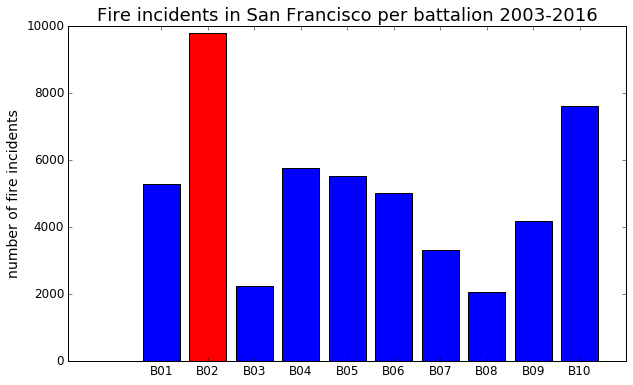

In [35]:
fire_categories_battalions = []
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        fire_categories_battalions.append(value["battalion"])
        
fire_categories_battalions_count = Counter(fire_categories_battalions)

fire_categories_battalions_sorted = sorted(fire_categories_battalions_count.items(), key=operator.itemgetter(0))

battalions_names = [x[0] for x in fire_categories_battalions_sorted]
labels = range(len(battalions_names))
values = [x[1] for x in fire_categories_battalions_sorted]

# Highest value
max_idx, max_val = max(enumerate(values), key=operator.itemgetter(1))

plt.figure(figsize=(10,6))
plt.bar(labels, values, align='center')
plt.bar(labels[max_idx], values[max_idx], align='center', color='red')
plt.title("Fire incidents in San Francisco per battalion 2003-2016", fontsize=18)
plt.ylabel('number of fire incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(labels, battalions_names, fontsize=12)
plt.show()

This plot confirms our assumptions that the battalions correlate with the districts' data. Fire stations in battalion B02 are located throughout the largest districts. Battalion B10 also has many incidents, which can be explained by the fact that it has the most number of fire stations or 7.

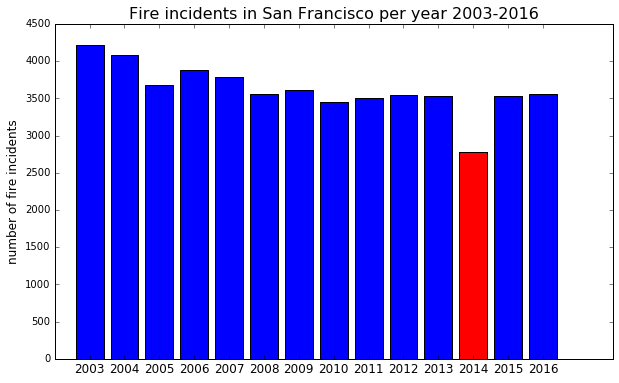

In [36]:
fire_incidents_year = []
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        fire_incidents_year.append(value["year"])
        
fire_incidents_year_count = Counter(fire_incidents_year)

fire_incidents_year_sorted = sorted(fire_incidents_year_count.items(), key=operator.itemgetter(0))

labels = [x[0] for x in fire_incidents_year_sorted]
values = [x[1] for x in fire_incidents_year_sorted]

min_idx, min_val = min(enumerate(values), key=operator.itemgetter(1))

plt.figure(figsize=(10,6))
plt.bar(labels, values, align='center')
plt.bar(labels[min_idx], values[min_idx], align='center', color='red')
plt.title('Fire incidents in San Francisco per year 2003-2016', fontsize=16)
plt.ylabel('number of fire incidents', fontsize=12)
plt.xticks(labels, fontsize=12)
plt.show()

Plot for fire incidents per year is interesting for the noticeable reduction in fire incidents for the year 2014. Unfortunately, further research did not provide any answers for this and this still remains a mystery. It could be that the data was mishandled during that year.

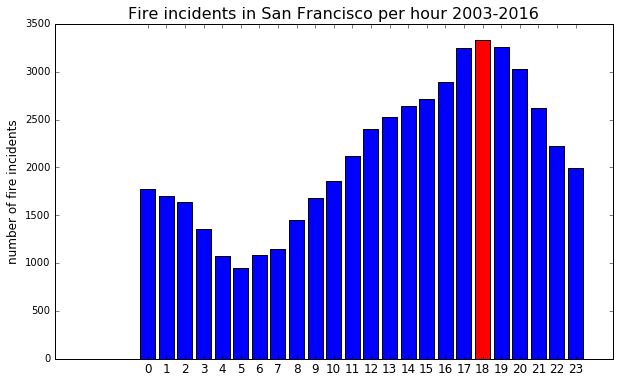

In [37]:
fire_incidents_hour = []
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        fire_incidents_hour.append(value["hour"])
        
fire_incidents_hour_count = Counter(fire_incidents_hour)

fire_incidents_hour_count_sorted = sorted(fire_incidents_hour_count.items(), key=operator.itemgetter(0))

labels = [x[0] for x in fire_incidents_hour_count_sorted]
values = [x[1] for x in fire_incidents_hour_count_sorted]

max_idx, max_val = max(enumerate(values), key=operator.itemgetter(1))

plt.figure(figsize=(10,6))
plt.bar(labels, values, align='center')
plt.bar(labels[max_idx], values[max_idx], align='center', color='red')
plt.title('Fire incidents in San Francisco per hour 2003-2016', fontsize=16)
plt.ylabel('number of fire incidents', fontsize=12)
plt.xticks(labels, fontsize=12)
plt.show()

The plot shows steady increase in fire incidents from 5 in the morning till 19 in the evening. The spike at dinner time is possibly related to increase in cooking and therefore fire incidents related to cooking.

#### 2.2.2 Fire incidents - ratio based on battalion

Next step is to plot the top 10 fire categories based on how often they occur in an area as compared to the total number of fire incidents for the whole of San Francisco. Therefore, we need to find their ratio in different areas. We will use the battalions as areas.

In [38]:
# Add to dictionary the probability of a fire category by dividing number
# of incidents in a fire category with the total number of fire incidents
fire_category_prob = {}
for i in fire_categories_sorted:
    fire_category_prob[i[0]] = float(i[1])/len(fire_categories)

Next, we calculate the same probability distribution but for each battalion.

In [39]:
battalion_fire_categories_ratio = defaultdict(list)
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        battalion_fire_categories_ratio[value["battalion"]].append(value["fire_code_info"])

In [40]:
battalion_fire_categories_prob = {}
for key, value in battalion_fire_categories_ratio.iteritems():
    # Get total number of fire incidents within a category
    fire_category_counter = Counter(value)
    # Iterate over 'fire_category_counter' and divide each fire category
    # with the total number of fire incidents within the battalion
    battalion_fire_category_prob = {}
    for cat, num in fire_category_counter.iteritems():
        battalion_fire_category_prob[cat] = float(num)/len(value)
    # Add values for each fire category to a dictonary for every battalion
    battalion_fire_categories_prob[key] = battalion_fire_category_prob

Now we look at the ratio P(fire category|battalion)/P(fire category). That ratio is equal to 1 if the fire category occurs at the same level within a battalion as in the city as a whole. If it's greater than one, it means that the fire category occurs more frequently within that battalion. If it's smaller than one, it means that the fire category is rarer within the battalion in question than in the city as a whole.

In [41]:
battalion_fire_categories_ratio = {}
# Go through each district
for key, value in battalion_fire_categories_prob.iteritems():
    # Divide probability of fire category within a battalion with the
    # same fire category for the whole city and add to dictonary
    battalion_fire_category_ratio = {}
    for cat, prob in value.iteritems():
        battalion_fire_category_ratio[cat] = float(prob)/fire_category_prob[cat]
    # Add values for each fire category to a dictonary for every battalion
    battalion_fire_categories_ratio[key] = battalion_fire_category_ratio

In [42]:
top_10_fire_categories = [x[0] for x in fire_categories_sorted[0:10]]

battalion_fire_categories_10_ratio = {}
for key, value in battalion_fire_categories_ratio.iteritems():
    fire_categories_10_ratio = {}
    for cat, ratio in value.iteritems():
        if (cat in top_10_fire_categories):
            fire_categories_10_ratio[cat] = ratio
    battalion_fire_categories_10_ratio[key] = fire_categories_10_ratio

We will now plot these ratios for each battalion and see if there are any apparent fire categories that stick out.

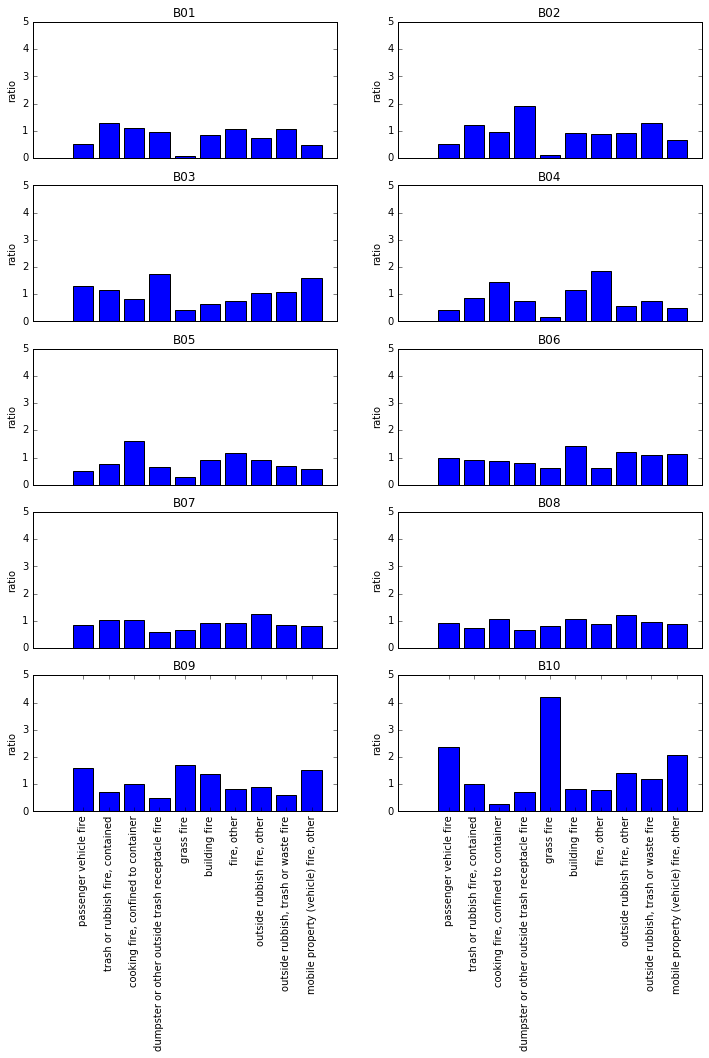

In [43]:
plt.subplots(figsize=(12,20))

# Plot the first 8 districts
for idx, value in enumerate(battalions_names):
    labels_names = battalion_fire_categories_10_ratio[value].keys()
    labels = range(len(labels_names))
    values = battalion_fire_categories_10_ratio[value].values()
    
    indexes = np.arange(len(labels))
    width = 0.8
    plt.subplot(7,2,(idx + 1))
    plt.bar(labels, values, align='center')
    plt.title(value)
    plt.ylabel('ratio')
    plt.yticks(range(6))
    if (idx == 8 or idx == 9):
        plt.xticks(labels, labels_names, rotation=90)
    else:
        plt.xticks([])

plt.show()

Here we see that few fire categories stand out. B10 has many grass fires and mobile property fires compared to the rest of the city. B10 is on the outskirts of the city. In the city, dumpster fires are happening more often than in other areas, as seen by B02 and B03. There is also very few grass fires in the battalions located downtown compared to the rest of the city, as seen by battalions B01, B02 and B04.

#### 2.2.3 Mean response time

We will now look at the mean response time for different attributes and try to see if there are any seasonal or other trends in the data. This will be helpful further down the road when we will try to predict the response time using multiple regression.

In [44]:
# Function for caluclating mean response time based on attribute,
# plotting the results and write to a csv-file
def mean_response_time_stats(attribute):
    response_times = defaultdict(list)
    for key, value in fire_incidents_info.iteritems():
        response = value["response_time"]
        response_times[value[attribute]].append(response)

    response_times_mean = []
    for key, value in response_times.iteritems():
        response_times_mean.append((key, np.mean(value)))
               
    # Plot figure
    labels_names = [x[0] for x in sorted(response_times_mean)]
    labels = range(len(labels_names))
    values = [x[1] for x in sorted(response_times_mean)]
    
    rotation = 0
    
    if (attribute == "weekday"):
        labels_names = days_of_the_week
    if (attribute == "month"):
        labels_names = months
        rotation = 90
    if (attribute == "fire_station"):
        rotation = 90

    max_idx, max_val = max(enumerate(values), key=operator.itemgetter(1))

    plt.figure(figsize=(12,5))
    plt.bar(labels, values, align='center')
    plt.bar(labels[max_idx], values[max_idx], align='center', color='red')
    plt.title('Mean response time per %s 2003-2016' % attribute.replace("_", " "), fontsize=16)
    plt.ylabel('seconds', fontsize=12)
    plt.xticks(labels, labels_names, fontsize=12, rotation=rotation)
    plt.show()
    
    with open("./data/mean_response_time_%s.csv" % attribute, "wb") as f:
        writer = csv.writer(f)
        writer.writerow((attribute, "mean_response_time"))
        writer.writerows(zip(labels_names, values))

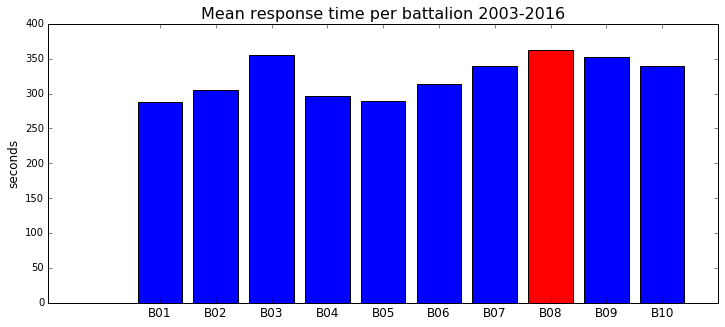

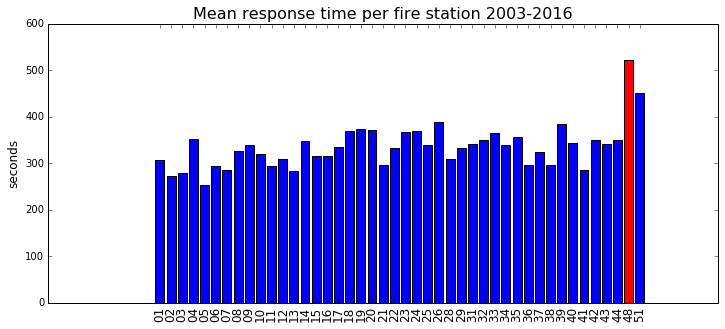

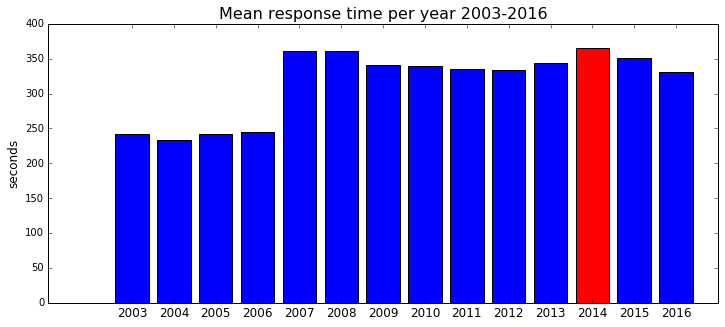

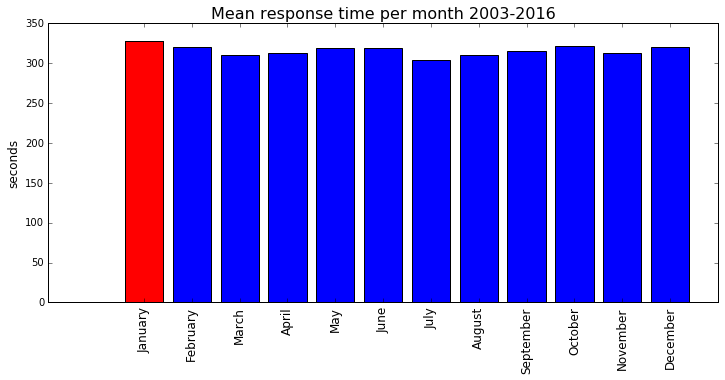

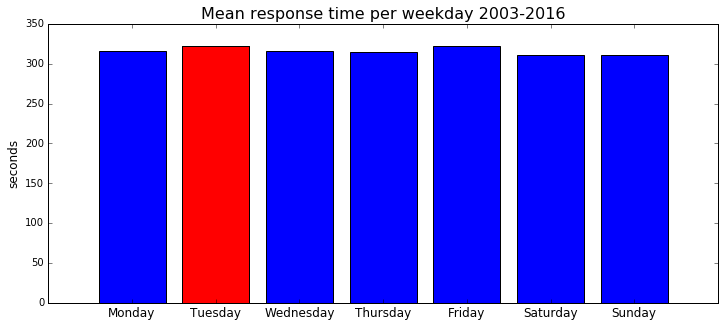

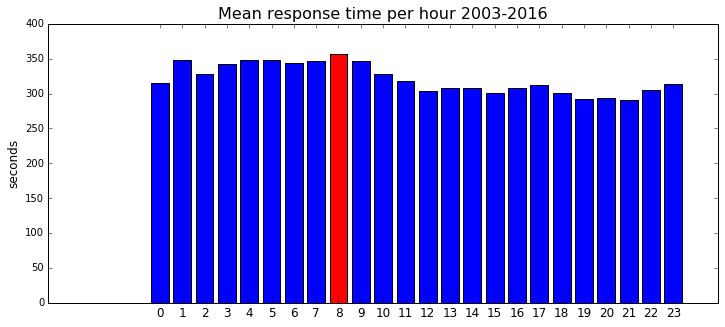

In [45]:
mean_response_time_stats("battalion")
mean_response_time_stats("fire_station")
mean_response_time_stats("year")
mean_response_time_stats("month")
mean_response_time_stats("weekday")
mean_response_time_stats("hour")

The data in these 6 plots is not very encouraging. There seems to be no obvious trends in the plots, except for sudden spike in response time from the year 2007 and onward, but that is likely related to inefficient data from the previous years.

#### 2.2.4 Mean meters per seconds

It is not enough to only know the response time, distance to the incident is also vital. One can assume that longer the distance, the higher the response time. We will test the hypothesis by plotting the response time and distance in a scatter plot to see if there is any correlation between these two attributes.

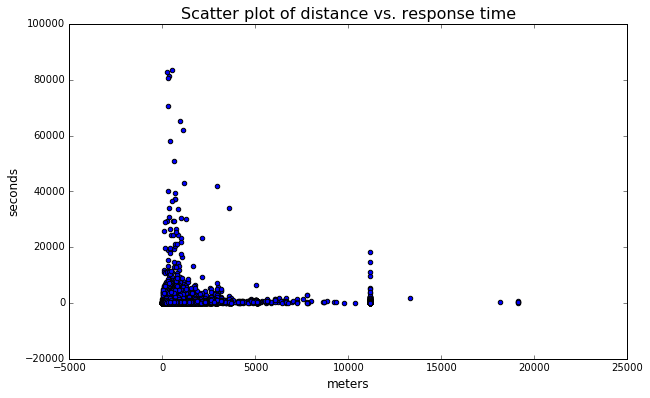

In [46]:
distances = []
response_times = []
for key, value in fire_incidents_info.iteritems():
    if (value["distance"] != "N/A"):
        distances.append(value["distance"])
        response_times.append(value["response_time"])
    
plt.figure(figsize=(10,6))
plt.scatter(distances, response_times)
plt.title('Scatter plot of distance vs. response time', fontsize=16)
plt.ylabel('seconds', fontsize=12)
plt.xlabel('meters', fontsize=12)
plt.show()

There are many strange values in the plot, for example values that have high response time but relatively short distance and values with long distances but very low response times. It also clear that many incidents have the response time 0, which could possibly be explained by insufficient data entering, because we get similar results when we only plot for data observations related to building fires (fire code 111). We will look better into these outliers when we train the model for multiple regression.

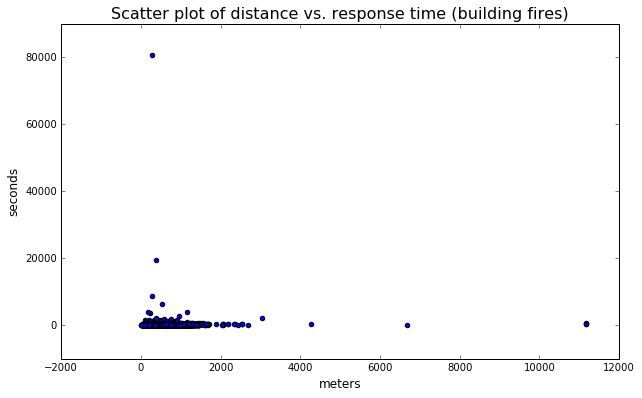

In [47]:
distances_111 = []
response_times_111 = []
for key, value in fire_incidents_info.iteritems():
    if (value["distance"] != "N/A" and value["fire_code"] == "111"):
        distances_111.append(value["distance"])
        response_times_111.append(value["response_time"])
    
plt.figure(figsize=(10,6))
plt.scatter(distances_111, response_times_111)
plt.title('Scatter plot of distance vs. response time (building fires)', fontsize=16)
plt.ylabel('seconds', fontsize=12)
plt.xlabel('meters', fontsize=12)
plt.show()

Therefore, we look at the attribute meters per second. The following six plots show some interesting distribution. There are more spikes in the plots than was for the response time.

In [48]:
# Function for caluclating mean meters per seconds based on attribute,
# plotting the results and write to a csv-file
def mean_m_per_s_stats(attribute):
    m_per_s_values = defaultdict(list)
    for key, value in fire_incidents_info.iteritems():
        m_per_s = value["m_per_s"]
        if (m_per_s != "N/A"):
            m_per_s_values[value[attribute]].append(m_per_s)

    m_per_s_mean = []
    for key, value in m_per_s_values.iteritems():
        m_per_s_mean.append((key, np.mean(value)))
        
    # Plot figure
    labels_names = [x[0] for x in sorted(m_per_s_mean)]
    labels = range(len(labels_names))
    values = [x[1] for x in sorted(m_per_s_mean)]
    
    rotation = 0
    
    if (attribute == "weekday"):
        labels_names = days_of_the_week
    if (attribute == "month"):
        labels_names = months
        rotation = 90
    if (attribute == "fire_station"):
        rotation = 90

    max_idx, max_val = max(enumerate(values), key=operator.itemgetter(1))

    plt.figure(figsize=(12,5))
    plt.bar(labels, values, align='center')
    plt.bar(labels[max_idx], values[max_idx], align='center', color='red')
    plt.title('Mean m/s per %s 2003-2016' % attribute.replace("_", " "), fontsize=16)
    plt.ylabel('m/s', fontsize=12)
    plt.xticks(labels, labels_names, fontsize=12, rotation=rotation)
    plt.show()
    
    with open("./data/mean_m_per_s_%s.csv" % attribute, "wb") as f:
        writer = csv.writer(f)
        writer.writerow((attribute, "mean_m_per_s"))
        writer.writerows(zip(labels_names, values))

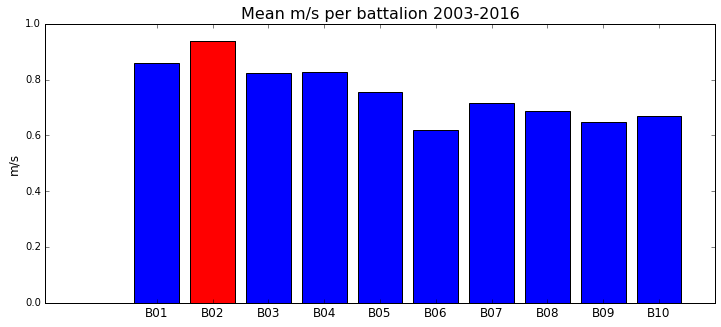

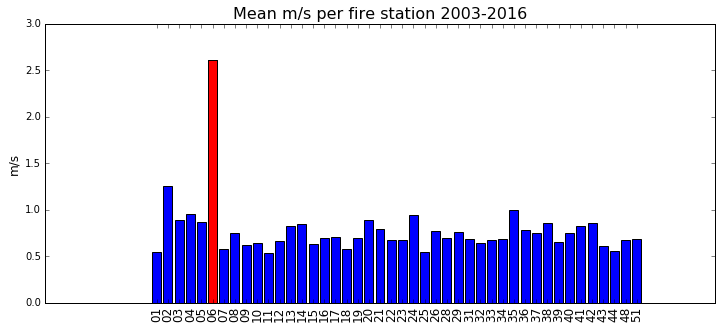

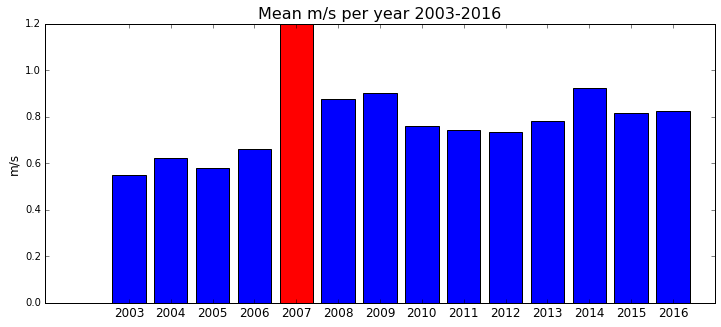

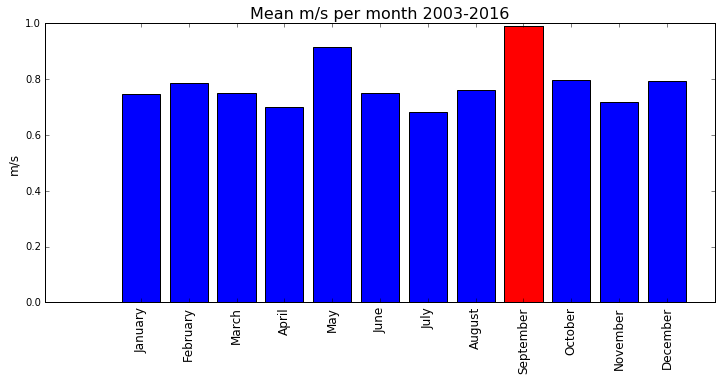

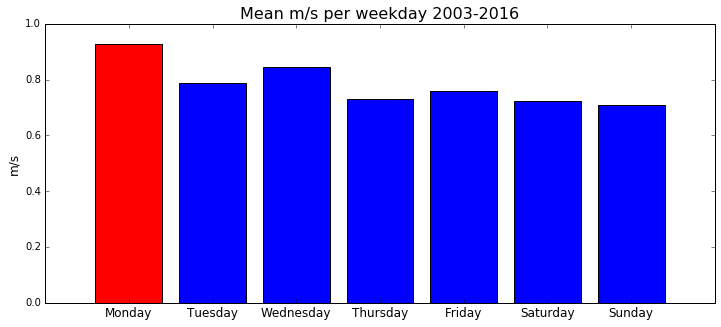

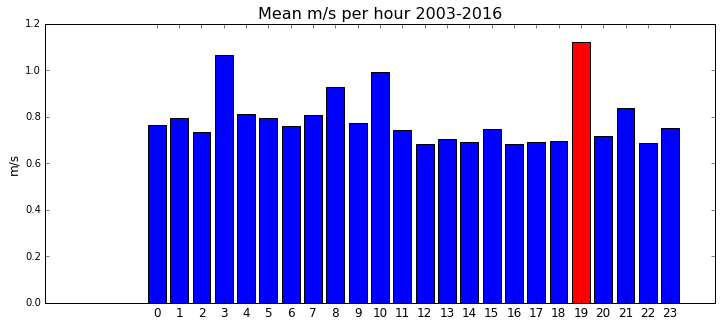

In [49]:
mean_m_per_s_stats("battalion")
mean_m_per_s_stats("fire_station")
mean_m_per_s_stats("year")
mean_m_per_s_stats("month")
mean_m_per_s_stats("weekday")
mean_m_per_s_stats("hour")

In the plots there are most spikes for the attributes hour, year, month, weekday and different fire stations. We will use these attributes for our multiple regression model, but with a slightly tweaked version of the meters per seconds. The plan is to calculate the mean m/s for each fire station for each hour. So each fire station has 24 data points of mean m/s.

## 3. Theory

We will use three machine learning tools on the data.

* Multiple regression to predict the response time
* Decision tree to predict in which area a given fire incident is likely to happen
* K-means clustering to identify clusters in San Francisco based on building fires

### 3.1 Multiple regression

We use multiple regression to predict the response time because we want to see if some attributes are better than other in predicting the response time, and if there is a relationship between the attributes.

We start by getting mean m/s for each hour for each fire station as described in chapter 2.2.4.

In [50]:
# Go through 'fire_incidents_info' and get all 'hour' and 'm_per_s' values
# and add to dictionary where the fire station is the key
fire_stations_m_per_s_hour_all = defaultdict(list)
for key, value in fire_incidents_info.iteritems():
    if (m_per_s != "N/A"):
        fire_stations_m_per_s_hour_all[value["fire_station"]].append([value["hour"], value["m_per_s"]])
        
# Order the dictionary so each 'hour' is a key with all of its 'm_per_s' as values
fire_stations_m_per_s_hour = {}
for key, value in fire_stations_m_per_s_hour_all.iteritems():
    m_per_s_hour = defaultdict(list)
    for i in value:
        m_per_s_hour[i[0]].append(i[1])
            
    # Add to dictionary, fire station is key
    fire_stations_m_per_s_hour[key] = m_per_s_hour
        
# Calculate the mean for each hour value for each fire station and add to a dictionary
fire_stations_m_per_s_hour_mean = {}
for key, value in fire_stations_m_per_s_hour.iteritems():
    m_per_s_hour_mean = defaultdict(list)
    for hour, m_per_s in value.iteritems():
        m_per_s_hour_mean[hour].append(np.mean(m_per_s))
        
    fire_stations_m_per_s_hour_mean[key] = m_per_s_hour_mean

#### 3.1.1 Outliers

We will do a simple percentile score analysis to see if there is some strange datapoints or outliers in our data, and then exclude those values from our model.

In [51]:
response_time_all = []
for key, value in fire_incidents_info.iteritems():
    response_time_all.append(value["response_time"])
    
percentile_range = [1, 2, 3, 4, 5, 95, 96, 97, 98, 99]

for i in percentile_range:
    score_at_percentile = str(stats.scoreatpercentile(response_time_all, i))
    print str(i) + "%: " + score_at_percentile

1%: 0.0
2%: 7.0
3%: 62.0
4%: 87.0
5%: 103.0
95%: 598.0
96%: 647.0
97%: 719.0
98%: 848.0
99%: 1181.0


As it can be seen here there are some strange values. Up to 3% of the data has response time less than 62 seconds and less than 1% of the data has response time that takes more than 19 minutes for the fire truck to reach its destination. As these data observations are quite incredible, we will exclude them from the model as they are not very representative of the data and would skew the model.

In [70]:
upper_limit = stats.scoreatpercentile(response_time_all, 99)
lower_limit = stats.scoreatpercentile(response_time_all, 3)

X = []
y = []
for key, value in fire_incidents_info.iteritems():
    if (value["lat"] != "N/A" and
        value["lon"] != "N/A" and
        value["district"] != "N/A" and
        lower_limit <= value["response_time"] <= upper_limit):
        
        fire_station_m_per_s_hour_mean = fire_stations_m_per_s_hour_mean[value["fire_station"]][value["hour"]][0]
        
        X.append([value["year"], value["month"], value["weekday"], value["distance"],
                  fire_station_m_per_s_hour_mean])

        y.append(value["response_time"])

X = np.array(X)
y = np.array(y)
# Normalize X to be in the range [0,1]
X_norm = X/X.max(axis=0)
print "Number of samples: %d" % len(X_norm)

Number of samples: 334437


#### 3.1.2 Model selection and cross-validation

The model will be trained on the attributes year, month, weekday, distance, fire_station_m_per_s_hour_mean (which are normalized in the range [0,1]) and response_time, using cross-validation.

The 334.437 observations are divided into 10 training and test samples, and compared with the mean response time of the observations. Each datapoint generated from the model (X_test) is subtracted from the real value (y_test). The mean value is then calculated from all of the absolute value datapoints in the subset, which gives the mean score for each subset (total of 10). The goal is to outperform the mean response time.

In [71]:
N, M = X_norm.shape

# Create cross-validation partition for evaluation
K = 10
CV = cross_validation.KFold(N,K,shuffle=True)

# Initialize variables
error_regression = np.empty((K,1))
error_mean = np.empty((K,1))

k=0
for train_index, test_index in CV:
    print('CV-fold {0} of {1}'.format(k+1, K))
    
    # Extract training and test set for current CV fold
    X_train = X_norm[train_index,:]
    y_train = y[train_index]
    X_test = X_norm[test_index,:]
    y_test = y[test_index]
    
    # Fit and evaluate multiple regression
    model = lm.LinearRegression()
    model = model.fit(X_train, y_train)
    y_est = model.predict(X_test)
    error_regression[k] = np.mean(abs(y_est-y_test)) 
    
    # Predict median of y_test
    y_mean = [np.mean(y)] * len(y_test)
    error_mean[k] = np.mean(abs(y_mean-y_test))
    
    k+=1
    
print "\nMultiple regression vs. mean"
for idx, error in enumerate(error_regression):
    print error[0], "vs.", error_mean[idx][0]
print "-------------------------------"
print np.mean(error_regression), "vs.", np.mean(error_mean)

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10

Multiple regression vs. mean
94.7709949463 vs. 104.949822412
93.1522362775 vs. 103.786683079
93.6455268946 vs. 104.008991495
94.2673944896 vs. 103.863095845
93.1861834202 vs. 103.465439793
94.2427965028 vs. 104.873825607
94.6274964232 vs. 104.969524414
94.3480454477 vs. 104.411951481
95.0957435406 vs. 105.562148661
93.6743371722 vs. 103.953192802
-------------------------------
94.1010755115 vs. 104.384467559


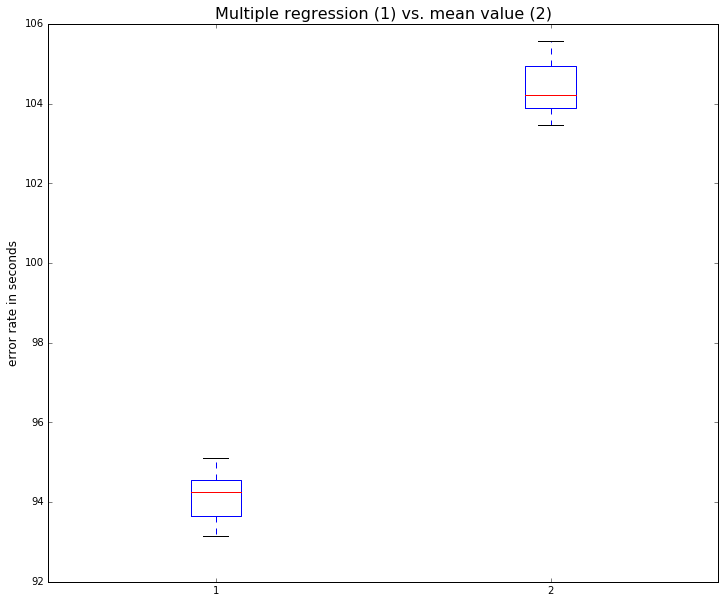

In [72]:
plt.figure(figsize=(12,10))
plt.boxplot(np.bmat('error_regression, error_mean'))
plt.title('Multiple regression (1) vs. mean value (2)', fontsize=16)
plt.ylabel('error rate in seconds', fontsize=12)
plt.show()

#### 3.1.3 Model performance

Multiple regression outperforms the mean response time in all of the 10 tests, by a margin approx. 10 seconds. The boxplots show the distribution of the mean values generated from the cross-validation.

This is still though far off from the right value, or about 1 minute and 30 seconds. This is what somewhat expected as there were no clear trends in the data when the attributes were plotted.

In [55]:
# Write the error rate to a csv-file
multiple_regression_error_rate = []
for idx, error in enumerate(error_regression):
    multiple_regression_error_rate.append([error[0], error_mean[idx][0]])
    
with open("./data/multiple_regression_performance.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(("multiple_regression", "mean_value"))
    writer.writerows(multiple_regression_error_rate)

### 3.2 Decision tree

Decision trees are excellent when dealing with classifying the data, which is relevant for our next problem; determining which class (battalion) a fire category is likely to happen in.

#### 3.2.1 Model selection and cross-validation

Chapter 2.2.2 gave us some insights into the battalions and which fire categories are happening more than average inside a battalion compared to the whole city. Therefore, we will use a decision tree to predict the battalion (the area) which fire category at a certain time is likely to happen in. The attributes which will be used are fire_code and part_of_the_day (X_train) and battalion (y_train).

The same method of cross-validation will be used as for multiple regression, except now we are calculating the misclassification rate. The decision tree either predicts the right battalion or the wrong. The decision tree will be compared with a simple model, which always predicts the largest class (B02). The goal is to outperform the simple model.

In [56]:
X_fire_codes = []
y_battalions = []
for key, value in fire_incidents_info.iteritems():
    if (value["fire_code"].startswith("1")):
        X_fire_codes.append([fire_codes.index(value["fire_code"]), value["part_of_the_day"]])
        y_battalions.append(value["battalion"])

X = np.array(X_fire_codes)
y = np.array(y_battalions)
print "Number of samples: %d" % len(X)

Number of samples: 50736


In [57]:
# Create cross-validation partition for evaluation
K = 10
CV = cross_validation.KFold(len(X),K,shuffle=True)

# Initialize variables
error_decision_tree = np.empty((K,1))
error_lc = np.empty((K,1))

k=0
for train_index, test_index in CV:
    print('CV-fold {0} of {1}'.format(k+1, K))
    
    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
       
    # Fit and evaluate decision tree
    model = tree.DecisionTreeClassifier(criterion="gini")
    model = model.fit(X_train, y_train)
    y_est = model.predict(X_test)
    error_decision_tree[k] = 100*(y_est!=y_test).sum().astype(float)/len(y_test)
    
    # Predict the largest class
    largest_class = max(set(y_battalions), key=y_battalions.count)
    y_lc = [largest_class] * len(y_test);                               
    error_lc[k] = 100*(y_lc!=y_test).sum().astype(float)/len(y_test)
    
    k+=1
    
print "\nDecision tree vs. largest class (%s)" % largest_class
for idx, error in enumerate(error_decision_tree):
    print error[0], "vs.", error_lc[idx][0]
print "-------------------------------"
print np.mean(error_decision_tree), "vs.", np.mean(error_lc)

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10

Decision tree vs. largest class (B02)
76.3500197083 vs. 80.1143082381
76.6653527789 vs. 81.4938904218
76.3697280252 vs. 79.7595585337
76.428852976 vs. 80.6464327946
77.2171856523 vs. 81.5727236894
76.2908947576 vs. 80.2719747734
76.9170116302 vs. 80.6031933767
76.2862211709 vs. 80.5243445693
77.074709245 vs. 81.4311058545
76.5621919968 vs. 80.5243445693
-------------------------------
76.6162167941 vs. 80.6941876821


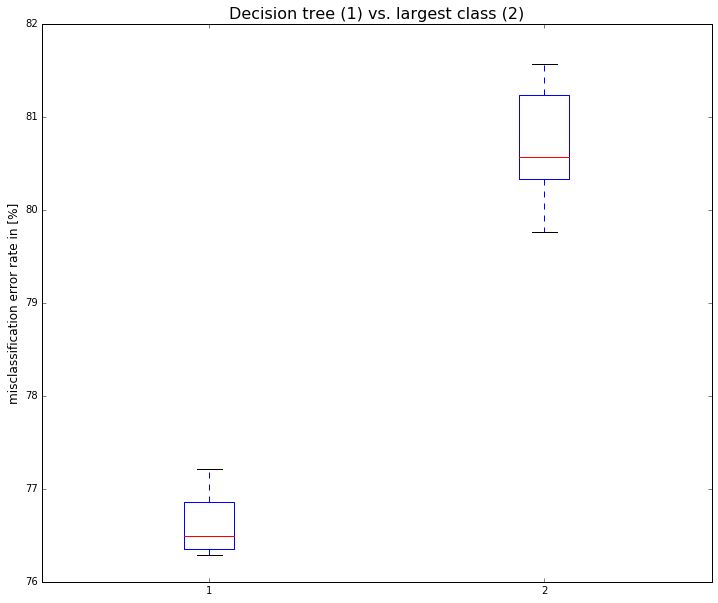

In [58]:
plt.figure(figsize=(12,10))
plt.boxplot(np.bmat('error_decision_tree, error_lc'))
plt.title('Decision tree (1) vs. largest class (2)', fontsize=16)
plt.ylabel('misclassification error rate in [%]', fontsize=12)
plt.show()

#### 3.2.2 Model performance

Decision tree outperforms the simple largest class model in every ten of the test subsets with a margin around 4%. This is still though, a very high misclassification rate by the model, around 76% are wrong predictions. This was expected because, as seen in chapter 2.2.2, there were not many indicators that some fire categories are happening more in other areas.

In [59]:
# Write the error rate to a csv-file
decision_tree_error_rate = []
for idx, error in enumerate(error_decision_tree):
    decision_tree_error_rate.append([error[0], error_lc[idx][0]])
    
with open("./data/decision_tree_performance.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(("decision_tree", "largest_class"))
    writer.writerows(decision_tree_error_rate)

### 3.3 K-means clustering

K-means clustering is used to identify potential clusters in the data. We will use this classifier to identify clusters in building fires by training models of K = 2, ..., 10. We start by plotting building fires on a map of San Francisco to get a sense of where they are happening.

In [60]:
# Plot the location of building fires in San Francisco
building_fires_lat = []
building_fires_lon = []
for key, value in fire_incidents_info.iteritems():
    if (value["lat"] != "N/A" and
        value["lon"] != "N/A" and
        value["fire_code"] == "111"):
        
        building_fires_lat.append(value["lat"])
        building_fires_lon.append(value["lon"])
    
geo_data_for_plotting = {"lat": building_fires_lat,
                         "lon": building_fires_lon}

bbox = BoundingBox(north=37.8265609, west=-122.5046487, south=37.7108786, east=-122.3694425)
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=3, cut_below=1e-4)
geoplotlib.inline()
print "Number of building fires: %d" % len(geo_data_for_plotting["lat"])

('smallest non-zero count', 1.9901719039787654e-09)
('max count:', 1.3395792084610685)


Number of building fires: 4666


#### 3.3.1 Model selection and squared errors

As stated before, we will train models for K = 2, ..., 10 and calculate the squared error rate for each K. We do that by squaring the difference between latitude and longitude of a datapoint and the latitude and longitude of its cluster. The results can been seen in the following plot.

In [61]:
# Train models of K = 2, …, 10
k_values = []
k_errors = []
for k in range(2,11):
    X = np.matrix(zip(building_fires_lat, building_fires_lon))
    kmeans = KMeans(n_clusters=k).fit(X)
    
    lat_lon = [list(a) for a in zip(building_fires_lat, building_fires_lon)]
    
    # Compare the distance between each 'latitudes' and 'longitudes' values to the cluster it belongs to 
    squared_errors = []
    for idx, val in enumerate(lat_lon):
        dist_lat = val[0] - kmeans.cluster_centers_[kmeans.labels_[idx]][0]
        dist_lon = val[1] - kmeans.cluster_centers_[kmeans.labels_[idx]][1]
        
        # Square the errors and get the sum for 'latitudes' and 'longitudes' values
        dist_squared = dist_lat**2 + dist_lon**2
        squared_errors.append(dist_squared)
        
    k_values.append(k), k_errors.append(sum(squared_errors))

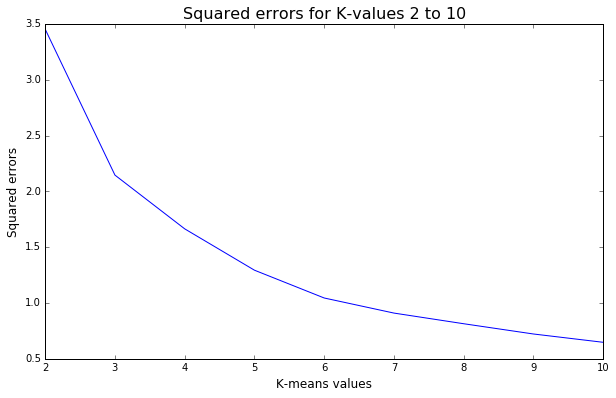

In [62]:
# Plot of k-means values and squared errors
plt.figure(figsize=(10,6))
plt.plot(k_values, k_errors)
plt.title('Squared errors for K-values 2 to 10', fontsize=16)
plt.xlabel('K-means values', fontsize=12)
plt.ylabel('Squared errors', fontsize=12)
plt.show()

#### 3.3.2 Model performance

Based on this plot the K should be 3, as the errors decrease the most from K=2 to K=3 and the errors do not decrease that much for the rest of the K values.

The optimal number of clusters is 3. The plot also shows that the building fires are not happening in isolated few locations around San Francisco, indicated by the steady decrease of the slope in the plot. If it would have been isolated in few locations, there would have been more drastic change from one K to another.

The cluster centers and the labels that belong to them can been seen [here](https://skuliskula.github.io/SDAFinalProject/).

In [63]:
# Create a list of lists for different labels for each k-means value from 2 to 6
k_labels = []
for k in range(2,7):
    X = np.matrix(zip(building_fires_lat, building_fires_lon))
    kmeans = KMeans(n_clusters=k).fit(X)
    k_labels.append(kmeans.labels_.tolist())
    
# Example from 'k_labels'
print "K2 labels (first 30 values):"
print k_labels[0][0:30]
print "K6 labels (first 30 values):"
print k_labels[4][0:30]

K2 labels (first 30 values):
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
K6 labels (first 30 values):
[5, 5, 5, 5, 4, 0, 1, 5, 2, 5, 4, 0, 5, 2, 5, 1, 2, 2, 2, 5, 1, 0, 5, 0, 4, 0, 5, 5, 5, 5]


In [64]:
# Write to a csv-file
with open("./data/k_means_building_fires_cluster_labels.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(("lat", "lon", "k2", "k3", "k4", "k5", "k6"))
    writer.writerows(zip(building_fires_lat, building_fires_lon,
                         k_labels[0], k_labels[1], k_labels[2], k_labels[3], k_labels[4]))

In [65]:
# Create a dictionary of cluster centers for each k value from 2 to 6
k_clusters = defaultdict(list)
for k in range(2,7):
    X = np.matrix(zip(building_fires_lat, building_fires_lon))
    kmeans = KMeans(n_clusters=k).fit(X)
    
    for i in kmeans.cluster_centers_:
        k_cluster = {}
        k_cluster["lat"] = i[0]
        k_cluster["lon"] = i[1]
        k_clusters["k" + str(k)].append(k_cluster)
        
# Example from 'k_clusters'
print "K2 cluster centers:"
print k_clusters["k2"]
print "K6 cluster centers:"
print k_clusters["k6"]

K2 cluster centers:
[{'lat': 37.738564185467993, 'lon': -122.43500634239983}, {'lat': 37.781848502300058, 'lon': -122.41976965786461}]
K6 cluster centers:
[{'lat': 37.787407630882932, 'lon': -122.4114183065074}, {'lat': 37.781316611333217, 'lon': -122.4395873285189}, {'lat': 37.756911932149031, 'lon': -122.41972697738308}, {'lat': 37.721599504614765, 'lon': -122.45384176038753}, {'lat': 37.727593909746744, 'lon': -122.39914369375131}, {'lat': 37.763937160747759, 'lon': -122.48646495034671}]


In [68]:
# Write to a json-file
with open('./data/k_means_building_fires_cluster_centers.json', 'w') as f:
    json.dump(k_clusters, f)

## 4. Visualizations

Taking a dataset and encode it will help our brain to understand it. The human eye is extremely good at processing large quantities of information and spotting patterns. That's why we visualize our data.

### 4.1 Notebook 

#### 4.1.1 Map

We chose to show a map of San Francisco so the user will understand better the geological distribution of fire stations and battalions. This makes it more easier to see how the SFFD groups its fire stations together and which area they cover.

#### 4.1.2 Bar charts

There are lot of fire categories in the dataset, or 176. It is never easy to show a distribution of so many categories, therefore it was decided to only show the top 30 in a bar chart, to get a better overview of what kind of incidents are in the data and their distribution. Furthermore, as most people associate Fire Departments with fire incidents a bar chart of the top ten fire categories and their distribution are also shown in a bar chart.

Bar charts were also used to show the difference between years, months, weekdays, hours, battalions and fire stations. These bar charts focused on number of incidents, mean response time and minutes per seconds. The latter two were vital to plot because it helped us to decide which attributes were relevant for the multiple regression model.

The ratio showing how likely a fire category was to happen in a battalion were plotted using subplots of bar charts, making it easy to see the difference between each battalion and the likelihood of fire categories happening more or less in certain battalions.

#### 4.1.3 Scatter plots

We wanted to see if there was correlation between the distance and the response time and good way to illustrate that is using scatter plots, and the plot also showed some interesting outliers.

#### 4.1.4 Box plots

The performance of the multiple regression and the decision tree were plotted using box plots, and compared to the simple models of the mean response time and the largest class, respectively. Using a box plot is an excellent way of grouping together scores from different tests and showing the median score, which can be helpful if the tests are showing very different outcomes. This was though not the case with our tests as they were all showing similar results.

#### 4.1.4 Heat map and line plot

Finally, the distribution of building fires were plotted using a heat map to see if there were any obvious clusters. Results from the K-means clustering were plotted in a simple line chart. There it was apparent that the optimal cluster size was 3. Very easy to see in a plot, while it would take some time to get interpret the results by simply looking at the squared error numbers in a table.


### 4.2 Website

#### 4.2.1 Maps

The first map shows the locations of all the fire stations. When you hover over a station circle you get more detailed information about that station in a tooltip. Using a tooltip minimizes the need for displaying a lot of text on the map itself. The station circles are then colored to show what battalion they belong to. Doing that you can almost instantly see how the stations are distributed. You can also zoom in on the map by clicking on an area, that way you can focus on different areas of San Francisco that makes it even more easier to visualize the distribution of the fire stations.

The second map shows the K-means clustering and where the cluster centers and their labels are located for K = 2, ..., 6. Each button is dedicated to one K view.

#### 4.2.2 Bubble chart

The bubble chart shows number of incidents and the mean response time for each battalion. The size of the bubbles are relative to the number of incidents, that makes it easier to see what battalion has most incidents. The bubble in the middle then displays the mean response time.


#### 4.2.3 Bar charts

The bar charts shows number of incidents that have occurred each year, month, day and hour. Using a bar chart for a comparison like this makes it easy to instantly see the distribution of the incidents. When you hover the mouse over a bar it shows you the exact number of incidents in a tooltip. That allows the user to easily see what bar has more incidents if the bars look extremely even in the chart. We chose to change the values of the y-axis accordingly to the number of incidents for each group because the groups we are comparing are different.


#### 4.2.4 Box charts

The box charts are good way to illustrate the performance of how well the machine learning tools were performing compared to the simple models.

## 5. Discussion

The data preprocessing went well and adding the fire stations locations gave us more data to work with, especially related to the multiple regression as the distance was one of the attributes used to predict the response time.

The dataset from the SFFD is not 100% perfect, but that can be expected. Many incidents were missing geolocations or around 15%. It is also worth to mention that the alarm time and the arrival time were often the one and the same even for incidents related to building fires.

This resulted in many outliers and that is something which should be improved on for this dataset. Outliers detection methods such as Gaussian Kernel density or KNN density could be a good way to remove those outliers, and perhaps would improve the multiple regression model.

There were no obvious seasonal trends in the data for the response time, which made it quite a challenge to predict the response time. The model could have been improved by using feature selection which would help to determine which combination of attributes would have made a better model. Nevertheless, both the models for multiple regression and decision tree outperformed their simple models, which was at least encouraging.